# Since 3D simulation is numerically very expensive, let's try to solve 1D potentials and compute wave function as product:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sympy as sp
from IPython.display import Math, display
from matplotlib.axes import Axes
from scipy import constants as const
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.signal import argrelmax,argrelmin,find_peaks
from tqdm import tqdm

import fewfermions.analysis.units as si
from fewfermions.simulate.traps.twod.trap import DoubleTweezer

In [2]:
initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 2*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)


## Try decomposing all 3D spatial directions:

In [3]:
n_pot_steps = [200,200,200]
n_levels = 4

left_cutoff = -0.5*initial_distance-2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
back_cutoff = -2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
front_cutoff = 2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
bottom_cutoff = -2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
top_cutoff = 2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

extend = [(left_cutoff,right_cutoff),
          (back_cutoff,front_cutoff),
          (bottom_cutoff,top_cutoff)]


# Solve the hamiltonian numerically in all directions
energies_x, states_x, potential_x, coords_x = trap.nstationary_solution(
        trap.x, extend[0], n_pot_steps[0], k=n_levels)

energies_y, states_y, potential_y, coords_y = trap.nstationary_solution(
        trap.y, extend[1], n_pot_steps[1], k=n_levels)

energies_z, states_z, potential_z, coords_z = trap.nstationary_solution(
        trap.z, extend[2], n_pot_steps[2], k=n_levels)

C:\Users\naeve\AppData\Local\Temp\ipykernel_3752\3500672162.py:46: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contour.collections:


KeyboardInterrupt: 

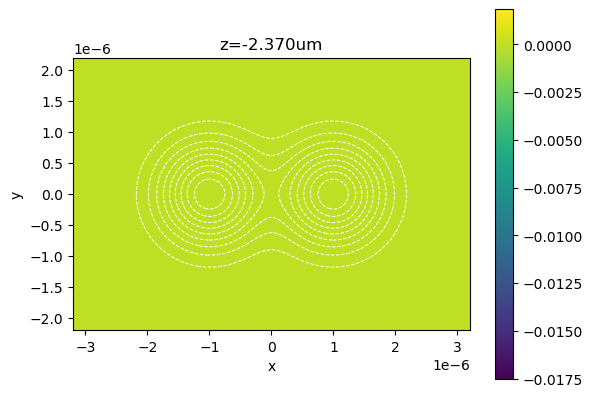

: 

In [ ]:
states_x3D = np.zeros((n_levels,*n_pot_steps))
states_y3D = np.zeros((n_levels,*n_pot_steps))
states_z3D = np.zeros((n_levels,*n_pot_steps))

for i in range(n_levels):
    states_x3D[i], states_y3D[i], states_z3D[i] = np.meshgrid(states_x[i],states_y[i],states_z[i])

states = states_x3D*states_y3D*states_z3D

# Generate spatial grid
x = np.linspace(*extend[0], n_pot_steps[0])
y = np.linspace(*extend[1], n_pot_steps[1])
z = np.linspace(*extend[2], n_pot_steps[2])

# Compute potential
pot_x = potential_x(x)
pot_y = potential_y(y)
pot_z = potential_z(z)

pot_x3D, pot_y3D, pot_z3D = np.meshgrid(pot_x,pot_y,pot_z)
pot = pot_x3D*pot_y3D*pot_z3D

state_number = 0

# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(states[state_number, :, :, 0], extent=[*extend[0], *extend[1]], origin="lower",
               vmin=np.min(states[state_number]), vmax=np.max(states[state_number]))

plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(im)

# Initialize contour as None before defining it globally
contour = None

# Animation update function
def update(frame):
    global contour  # Ensure we're modifying the global variable

    im.set_data(states[state_number, :, :, frame])  # Update image data
    ax.set_title(f"z={z[frame]/si.um:.3f}um")  # Update title

    # Remove old contours if they exist
    if contour is not None:
        for c in contour.collections:
            c.remove()

    # Redraw contour plot
    contour = ax.contour(pot[:, :, frame], levels=10, colors='white', linewidths=0.7, extent=[*extend[0], *extend[1]])

# Create the first contour plot after defining update()
contour = ax.contour(pot[:, :, 0], levels=10, colors='white', linewidths=0.7, extent=[*extend[0], *extend[1]])

# Create animation
frames = n_pot_steps[2]  # Number of slices
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

ani.save(f"animations/state{state_number}_decomp_all.gif", writer="pillow", fps=frames/5)  # Save as GIF

plt.show()


This seems to change the potential significantly and there are two minima in z direction.

## Try to decompose only the y direction (WIP):

In [59]:
n_pot_steps = [200,200,200]
n_levels = 4

left_cutoff = -0.5*initial_distance-2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
back_cutoff = -2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
front_cutoff = 2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
bottom_cutoff = -2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
top_cutoff = 2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

extend = [(left_cutoff,right_cutoff),
          (back_cutoff,front_cutoff),
          (bottom_cutoff,top_cutoff)]


# Solve the hamiltonian numerically in all directions
energies_xz, states_xz, potential_xz, coords_xz = trap.nstationary_solution(
        [trap.x,trap.z], extend[::2], n_pot_steps[::2], k=n_levels)

energies_y, states_y, potential_y, coords_y = trap.nstationary_solution(
        trap.y, extend[1], n_pot_steps[1], k=n_levels)

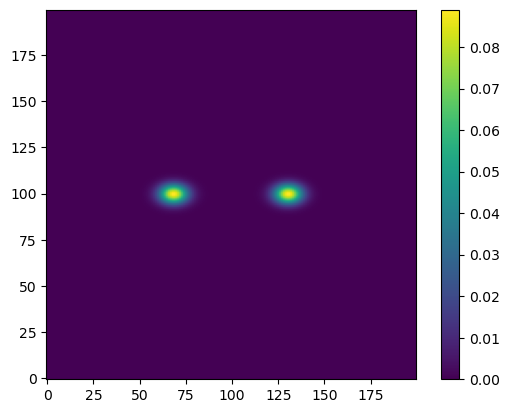

In [66]:
plt.imshow(states_xz[0],origin="lower")
plt.colorbar()

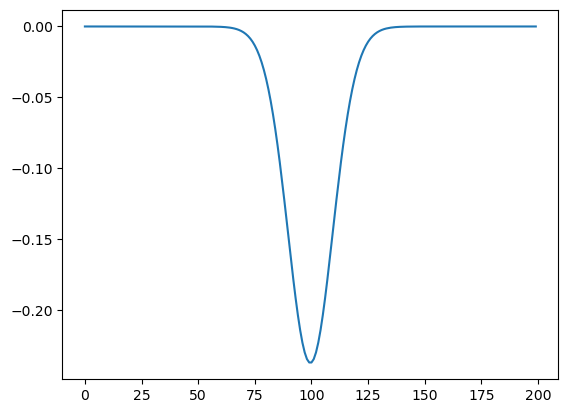

In [68]:
plt.plot(states_y[0])

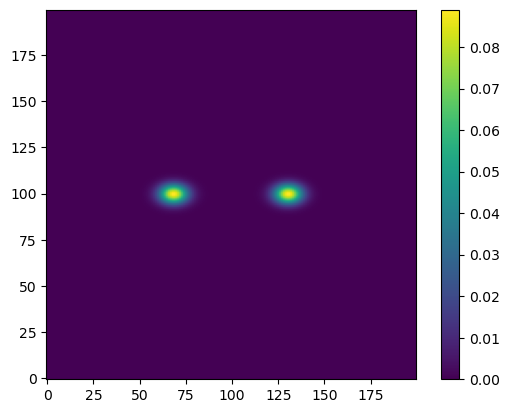

In [105]:
states = np.expand_dims(states_xz, axis=2)
states = np.repeat(states,n_pot_steps[2],axis=2)

plt.imshow(states[0,:,100,:],origin="lower")
plt.colorbar()

In [106]:
states = np.expand_dims(states_xz, axis=2)
states = np.repeat(states,n_pot_steps[2],axis=2)

for i in range(n_levels):
    for j in range(n_pot_steps[2]):
        states[i,:,j,:] *= states_y[i,j]

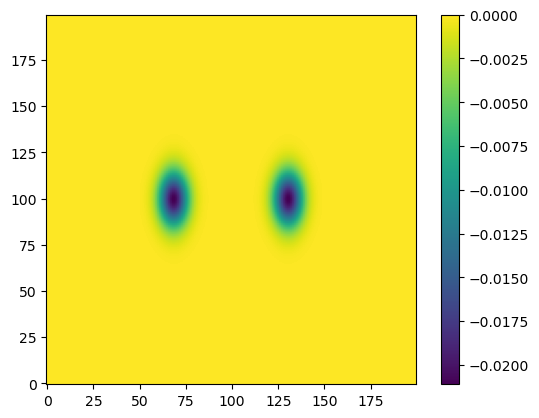

In [112]:
plt.imshow(states[0,100,:,:],origin="lower")
plt.colorbar()

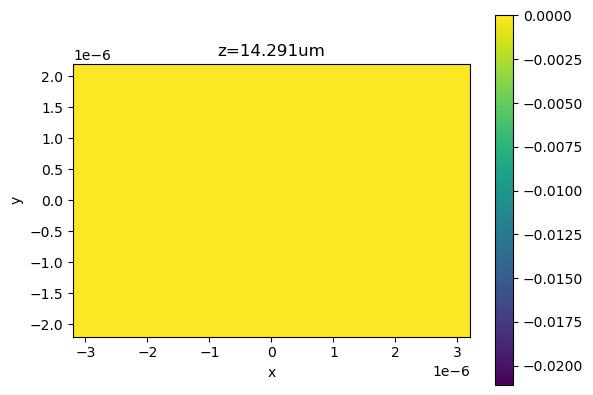

In [ ]:
# Generate spatial grid
x = np.linspace(*extend[0], n_pot_steps[0])
y = np.linspace(*extend[1], n_pot_steps[1])
z = np.linspace(*extend[2], n_pot_steps[2])


state_number = 0

# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(states[state_number, :, :, 0], extent=[*extend[0], *extend[1]], origin="lower",
               vmin=np.min(states[state_number]), vmax=np.max(states[state_number]))

plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(im)


# Animation update function
def update(frame):
    global contour  # Ensure we're modifying the global variable

    im.set_data(states[state_number, :, :, frame])  # Update image data
    ax.set_title(f"z={z[frame]/si.um:.3f}um")  # Update title


# Create animation
frames = n_pot_steps[2]  # Number of slices
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

ani.save(f"animations/state{state_number}_decomp_y.gif", writer="pillow", fps=frames/5)  # Save as GIF

plt.show()


In [ ]:
# Generate spatial grid
x = np.linspace(*extend[0], n_pot_steps[0])
y = np.linspace(*extend[1], n_pot_steps[1])
z = np.linspace(*extend[2], n_pot_steps[2])

# Compute potential
pot_x = potential_x(x)
pot_y = potential_y(y)
pot_z = potential_z(z)

pot_x3D, pot_y3D, pot_z3D = np.meshgrid(pot_x,pot_y,pot_z)
pot = pot_x3D*pot_y3D*pot_z3D

state_number = 0

# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(states[state_number, :, :, 0], extent=[*extend[0], *extend[1]], origin="lower",
               vmin=np.min(states[state_number]), vmax=np.max(states[state_number]))

plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(im)

# Initialize contour as None before defining it globally
contour = None

# Animation update function
def update(frame):
    global contour  # Ensure we're modifying the global variable

    im.set_data(states[state_number, :, :, frame])  # Update image data
    ax.set_title(f"z={z[frame]/si.um:.3f}um")  # Update title

    # Remove old contours if they exist
    if contour is not None:
        for c in contour.collections:
            c.remove()

    # Redraw contour plot
    contour = ax.contour(pot[:, :, frame], levels=10, colors='white', linewidths=0.7, extent=[*extend[0], *extend[1]])

# Create the first contour plot after defining update()
contour = ax.contour(pot[:, :, 0], levels=10, colors='white', linewidths=0.7, extent=[*extend[0], *extend[1]])

# Create animation
frames = n_pot_steps[2]  # Number of slices
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

ani.save(f"animations/state{state_number}_decomp_y.gif", writer="pillow", fps=frames/5)  # Save as GIF

plt.show()


TypeError: _lambdifygenerated() missing 1 required positional argument: 'z'